| Course | Submitted To | Submitted By | Date Submitted      | Term   |
|--------|------------|-----------|------------|--------|
| EAI6020 | Siddharth Rout, Faculty Lecturer | Abhilash Dikshit, Murtaza Vora, Gunjan Paladiya | Mar 2, 2024 | Winter 2024 |


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
data = pd.read_excel("/content/FL_Dashboard_AY2009_2010_Q1.xls", skiprows= 5)
display(data)

,OPE ID,School,State,Zip Code,School Type,Recipients,# of Loans Originated,$ of Loans Originated,# of Disbursements,$ of Disbursements,...,Recipients.2,# of Loans Originated.2,$ of Loans Originated.2,# of Disbursements.2,$ of Disbursements.2,Recipients.3,# of Loans Originated.3,$ of Loans Originated.3,# of Disbursements.3,$ of Disbursements.3
0,106100,ALASKA PACIFIC UNIVERSITY,AK,995084672,PRIVATE,291,291,1546994,292,830513,...,31,33,386770,35,192181,5,5,69730,5,34865
1,106300,UNIVERSITY OF ALASKA FAIRBANKS,AK,997757500,PUBLIC,1413,1434,6394735,1455,3290699,...,36,40,265784,40,138160,4,4,68620,4,28988
2,106500,UNIVERSITY OF ALASKA SOUTHEAST,AK,998018680,PUBLIC,406,409,1866473,439,1044946,...,8,8,88046,8,44024,0,0,0,0,0
3,1146200,UNIVERSITY OF ALASKA ANCHORAGE,AK,995088050,PUBLIC,2998,3042,12780036,3045,6440086,...,123,125,1288224,125,645683,9,11,43878,11,24063
4,2541000,ALASKA CAREER COLLEGE,AK,995071033,PROPRIETARY,38,38,103869,38,52178,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3815,393200,UNIVERSITY OF WYOMING,WY,820713663,PUBLIC,2699,2735,12341711,2738,6819888,...,195,207,1830536,209,950682,58,65,740877,66,416236
3816,393300,WESTERN WYOMING COMMUNITY COLLEGE,WY,829010428,PUBLIC,214,214,731883,215,359742,...,2,2,13300,2,6650,0,0,0,0,0
3817,728900,CENTRAL WYOMING COLLEGE,WY,825012215,PUBLIC,149,154,414959,154,212783,...,7,7,34978,7,17492,0,0,0,0,0
3818,915700,WYOTECH,WY,820729519,PROPRIETARY,1049,1099,2554580,1220,1498483,...,478,490,7567391,522,4033026,0,0,0,0,0


In [29]:
# Step 1: Clean the dollar amount columns
dollar_cols = [col for col in data.columns if col.startswith('$')]
for col in dollar_cols:
    # Remove $ and , characters and convert to float
    data[col] = data[col].replace('[\$,]', '', regex=True).astype(float)

In [30]:
# Step 2: Handle missing values (if any)
data = data.replace('-', 0)

In [31]:
# Step 3: Encode categorical variables using one-hot encoding
categorical_cols = ['School', 'State', 'School Type']
data = pd.get_dummies(data, columns=categorical_cols)


In [32]:
# Step 4: Normalize numerical features
from sklearn.preprocessing import StandardScaler

# Exclude OPE ID and Zip Code from the features (identifiers)
numerical_cols = [col for col in data.columns if col not in ['OPE ID', 'Zip Code'] + categorical_cols]
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

In [33]:
# Step 5: Select the target column for the regression problem
target_col = '$ of Loans Originated'
Y = data[target_col].values
data = data.drop(columns=[target_col]+['OPE ID', 'Zip Code'] )

# Step 6: Combine all the preprocessed features into a single features tensor (X)
X = data.values

In [34]:
X = np.nan_to_num(X).astype(np.float32)


In [35]:
pip install torch

In [36]:
import torch

# Convert to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y = np.array(Y).astype(np.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32).view(-1, 1)

# Check the shapes of the tensors
print(X_tensor.shape, Y_tensor.shape)

torch.Size([3820, 3633]) torch.Size([3820, 1])


In [37]:
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define the neural network structure
class RegressionNN(nn.Module):
    def __init__(self, input_size):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, 20)
        self.fc3 = nn.Linear(20, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Split the dataset into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_tensor, Y_tensor, test_size=0.2, random_state=42)

# Initialize the model
input_size = X_train.shape[1]
model = RegressionNN(input_size)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, epochs=100):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, Y_train)
        loss.backward()
        optimizer.step()

        # Validation loss
        model.eval()
        with torch.no_grad():
            val_output = model(X_val)
            val_loss = criterion(val_output, Y_val)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

    return train_losses, val_losses


In [38]:
print(len(train_losses), len(val_losses))

100 100


In [39]:
print(train_losses)
print(val_losses)

[8.72310010890942e-06, 8.722380698600318e-06, 8.722446182218846e-06, 8.724675353732891e-06, 8.728790817258414e-06, 8.736721611057874e-06, 8.748686013859697e-06, 8.76680678629782e-06, 8.792900189291686e-06, 8.830548722471576e-06, 8.884751878213137e-06, 8.96565688890405e-06, 9.079932169697713e-06, 9.246258741768543e-06, 9.482170753472019e-06, 9.827273970586248e-06, 1.0325232324248645e-05, 1.1052037734771147e-05, 1.2086282367818058e-05, 1.358129065920366e-05, 1.5637280739611015e-05, 1.838575553847477e-05, 2.155036236217711e-05, 2.4903165467549115e-05, 2.7591804609983228e-05, 2.863243753381539e-05, 2.6997011445928365e-05, 2.30884543270804e-05, 1.7393647794960998e-05, 1.2308770237723365e-05, 9.242311534762848e-06, 8.81586402101675e-06, 1.0509670573810581e-05, 1.3012746421736665e-05, 1.5004459783085622e-05, 1.5472138329641894e-05, 1.4426647794607561e-05, 1.233625880558975e-05, 1.0192875379289035e-05, 8.838685971568339e-06, 8.626199814898428e-06, 9.294901246903464e-06, 1.0330360055377241e-05,

Epoch 1/1000, Train Loss: 1.274990200996399, Val Loss: 0.889123797416687
Epoch 2/1000, Train Loss: 1.1796948909759521, Val Loss: 0.8733377456665039
Epoch 3/1000, Train Loss: 1.1204414367675781, Val Loss: 0.8596342206001282
Epoch 4/1000, Train Loss: 1.082598328590393, Val Loss: 0.846443235874176
Epoch 5/1000, Train Loss: 1.056073546409607, Val Loss: 0.8335791230201721
Epoch 6/1000, Train Loss: 1.0345615148544312, Val Loss: 0.820669949054718
Epoch 7/1000, Train Loss: 1.014163851737976, Val Loss: 0.807562530040741
Epoch 8/1000, Train Loss: 0.9935183525085449, Val Loss: 0.7942684888839722
Epoch 9/1000, Train Loss: 0.9723970890045166, Val Loss: 0.7806712985038757
Epoch 10/1000, Train Loss: 0.9502957463264465, Val Loss: 0.766662061214447
Epoch 11/1000, Train Loss: 0.927095890045166, Val Loss: 0.7522085905075073
Epoch 12/1000, Train Loss: 0.9025512933731079, Val Loss: 0.7377269864082336
Epoch 13/1000, Train Loss: 0.8766334056854248, Val Loss: 0.7228058576583862
Epoch 14/1000, Train Loss: 0.84

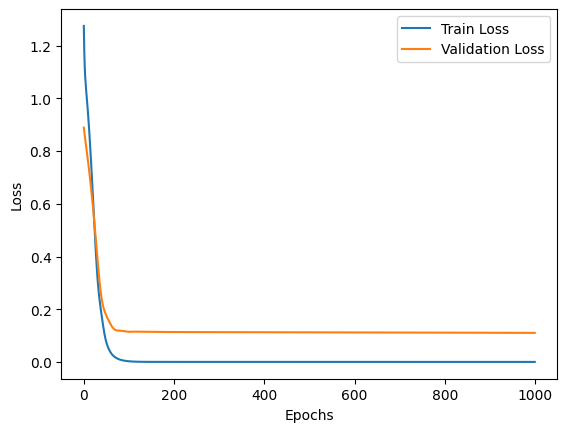

In [40]:
# Train the model and get the loss history
train_losses, val_losses = train_model(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, epochs=1000)

# Visualize the training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Record model performance
num_epochs = len(train_losses)
model_performance = pd.DataFrame({
    'Epoch': range(1, num_epochs + 1),
    'Train Loss': train_losses,
    'Validation Loss': val_losses
})

In [41]:
model_performance

,Epoch,Train Loss,Validation Loss
0,1,1.274990,0.889124
1,2,1.179695,0.873338
2,3,1.120441,0.859634
3,4,1.082598,0.846443
4,5,1.056074,0.833579
...,...,...,...
995,996,0.000036,0.110262
996,997,0.000036,0.110257
997,998,0.000036,0.110252
998,999,0.000036,0.110248


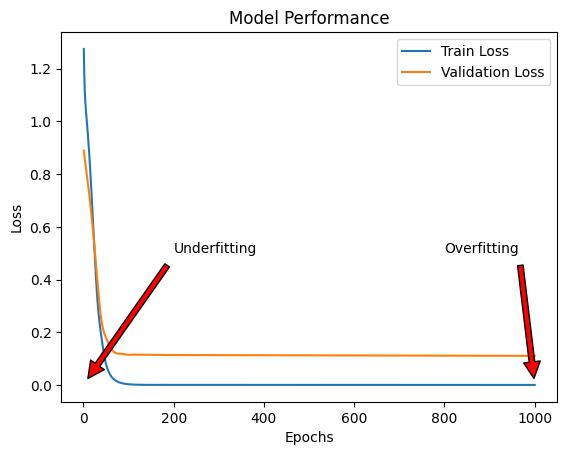

In [42]:
import matplotlib.pyplot as plt

# Plotting the training and validation losses
plt.plot(model_performance['Epoch'], model_performance['Train Loss'], label='Train Loss')
plt.plot(model_performance['Epoch'], model_performance['Validation Loss'], label='Validation Loss')

# Annotate underfitting and overfitting points
plt.annotate('Underfitting', xy=(0, 0), xytext=(200, 0.5),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.annotate('Overfitting', xy=(num_epochs, 0), xytext=(800, 0.5),
             arrowprops=dict(facecolor='red', shrink=0.05))

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Performance')
plt.legend()
plt.show()


For regression problems, we typically evaluate the performance using metrics such as Mean Squared Error (MSE), Mean Absolute Error (MAE), Root Mean Squared Error (RMSE)

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Compute regression metrics
mse = mean_squared_error(Y_val, Y_pred_val)
mae = mean_absolute_error(Y_val, Y_pred_val)
rmse = np.sqrt(mse)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Squared Error (MSE): 0.11024394
Mean Absolute Error (MAE): 0.19562115
Root Mean Squared Error (RMSE): 0.33203003


**Conclusion**

Mean Squared Error (MSE): The MSE measures the average squared difference between the predicted values and the actual values. In this case, the MSE is approximately 0.1102. A lower MSE indicates that the model's predictions are closer to the actual values on average. The MSE of 0.1102 suggests that the model's predictions have relatively low error on the validation set.

Mean Absolute Error (MAE): The MAE measures the average absolute difference between the predicted values and the actual values. The MAE is approximately 0.1956. Similar to MSE, a lower MAE indicates better performance. The MAE of 0.1956 suggests that, on average, the model's predictions are off by approximately 0.1956 units from the actual values.

Root Mean Squared Error (RMSE): The RMSE is the square root of the MSE and provides a measure of the spread of the errors. The RMSE is approximately 0.3320. A lower RMSE indicates better performance. The RMSE of 0.3320 suggests that, on average, the model's predictions are off by approximately 0.3320 units from the actual values.

**Suggestions**

The model seems to have relatively low errors, as indicated by the low values of MSE, MAE, and RMSE.
The predictions are, on average, close to the actual values, which indicates that the model is performing reasonably well on the validation set.

However, it's important to compare these metrics with the scale of the target variable to determine the practical significance of the errors.


**END**